### Cleaned vs Dirty V2
##### Classify if a plate is cleaned or dirty?
тип задачи - классификация \
метрика качества - accuracy(доля правильных ответов) \
transfer learning - дообучение готовой архитектуры 

Основная идея решения - дообучить ResNet 

In [21]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
import copy

In [22]:
import os
import zipfile

#with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
#    zip_obj.extractall('/kaggle/working/')
#data_root = '/kaggle/working/plates/'

In [23]:
data_root = 'plates/'

Для создания train и validation выборок, создадим и заполним 2 папки:

In [24]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']
#все картинки разбиваются на классы
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
#каждая 6 картинка помещается в папку validation
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 5290.75it/s]


In [25]:
!ls train

cleaned  dirty


### Предобработка
<b>torchvision.datasets.ImageFolder</b>
 - предоставляет возможность итерирования по изображениям, запомнит в какой папке-классе оно находилось
 - помогает получать изображения в виде тензоров
 
<b>transforms.Compose</b>
 - сжатие картинки до определенного размера
 - превращение ее в тензор
 - от каждого цвета отнимаются константы, т.к. на таких примерах обучался ResNet

In [26]:
import torch
import torchvision

from torchvision import transforms, models

#Аугментации
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), #вырезается прямоугольная часть и увеличивается до 224
    transforms.RandomHorizontalFlip(), #отзеркаливание
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

In [27]:
#num_workers - количество потоков выполняющих трансформации
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

permute - меняет местами размерности тензора Х
 - до .toTenzor: высота, ширина, каналы
 - после: каналы, высота, ширина  
 
permute+обратная нормировка = исходное изображение

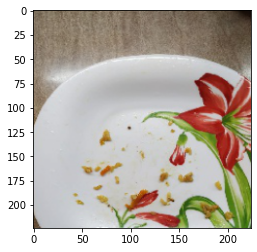

In [32]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

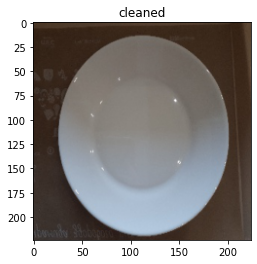

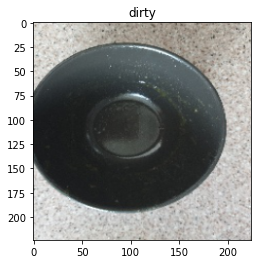

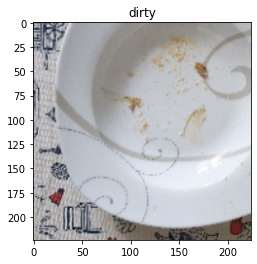

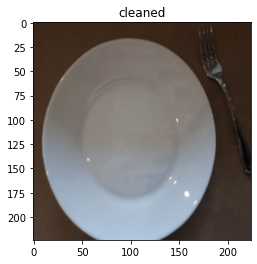

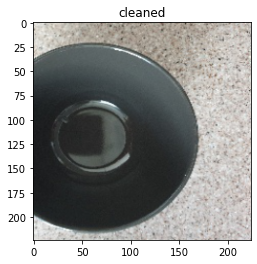

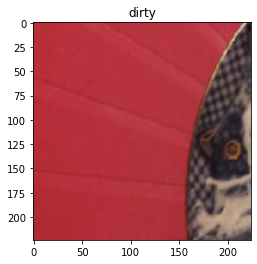

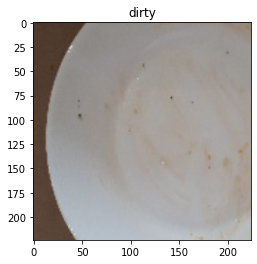

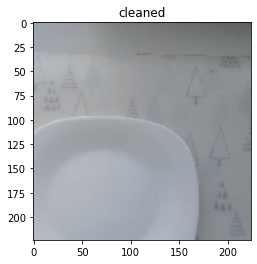

In [33]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

### Создание модели

In [34]:
model = models.resnet18(pretrained=True)

# для всех слоев отменяем вычисление градиентного спуска 
#т.к. параметры нас устраивают, модель уже обучена, осталось обучить последний слой - классификатор
for param in model.parameters():
    param.requires_grad = False


model.fc = torch.nn.Linear(model.fc.in_features, 2)


#перекладывание модели на GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#Бинарная кросс-энтропия получает активации нейронов
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3) #градиентный спуск lr - learning rate

# уменьшение lr с течением времени
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/nastya/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


/home/nastya/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [36]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    #итератор по эпохам
    for epoch in range(num_epochs): 
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1) #чтобы узнать предсказанный класс

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [38]:
train_model(model, loss, optimizer, scheduler, num_epochs=10);

Epoch 0/9:


100%|██████████| 4/4 [00:02<00:00,  1.73it/s]

train Loss: 0.4667 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

val Loss: 0.6269 Acc: 0.5000
Epoch 1/9:



100%|██████████| 4/4 [00:02<00:00,  1.38it/s]

train Loss: 0.4718 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

val Loss: 0.6253 Acc: 0.5000
Epoch 2/9:



100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

train Loss: 0.5511 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

val Loss: 0.6306 Acc: 0.6250
Epoch 3/9:



100%|██████████| 4/4 [00:03<00:00,  1.31it/s]

train Loss: 0.5591 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

val Loss: 0.6291 Acc: 0.6250
Epoch 4/9:



100%|██████████| 4/4 [00:03<00:00,  1.33it/s]

train Loss: 0.5201 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

val Loss: 0.6279 Acc: 0.6250
Epoch 5/9:



100%|██████████| 4/4 [00:03<00:00,  1.33it/s]

train Loss: 0.4895 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

val Loss: 0.6402 Acc: 0.6250
Epoch 6/9:



100%|██████████| 4/4 [00:03<00:00,  1.29it/s]

train Loss: 0.4916 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.23it/s]

val Loss: 0.6356 Acc: 0.5000
Epoch 7/9:



100%|██████████| 4/4 [00:03<00:00,  1.32it/s]

train Loss: 0.5171 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

val Loss: 0.6328 Acc: 0.6250
Epoch 8/9:



100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

train Loss: 0.5425 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

val Loss: 0.6385 Acc: 0.5000
Epoch 9/9:



100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

train Loss: 0.4401 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

val Loss: 0.6391 Acc: 0.5000
